In [1]:
# Main Imports
from ipynb.fs.full.GastricFunctions import *
#from GastricFunctions_py import *
import numpy as np
import pandas as pd
# Util function for convert-to (0 - 1) range
def rescale(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)

def rescale_AB(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return ( (arr - arr_min) / (arr_max - arr_min)  ) * 255 - 128

In [2]:
# Loading Results dataframe
# Prepare this dataframe (total results) only once
# total_results_dataframe = pd.DataFrame(columns=["Patient to be predicted/left out" , "Poor Survival Subpopulation" , "Moderate Survival Subpopulation" , "Good Survival Subpopulation", "Predicted Survivability", "Surv(months)" , "Survival Status" , "Number of Clusters"  , "SAM Features for each tSNE run on new subset"])
#total_results_dataframe_SVM = pd.DataFrame(columns=["Patient to be predicted/left out" , "Poor Survival Subpopulation" , "Moderate Survival Subpopulation" , "Good Survival Subpopulation", "Predicted Survivability", "Surv(months)" , "Survival Status" , "Number of Clusters"  , "SAM Features for each tSNE run on new subset"])
#total_results_dataframe_KNN = pd.DataFrame(columns=["Patient to be predicted/left out" , "Poor Survival Subpopulation" , "Moderate Survival Subpopulation" , "Good Survival Subpopulation", "Predicted Survivability", "Surv(months)" , "Survival Status" , "Number of Clusters"  , "SAM Features for each tSNE run on new subset"])

# Only load if needed to load total results from previous runs to continue on
total_results_dataframe_SVM = pd.read_csv("total_GastricCancer_results_SVM.csv")
total_results_dataframe_KNN = pd.read_csv("total_GastricCancer_results_KNN.csv")


In [3]:
# Reading Data
HE_image , MSI_data_cube , goodlist, peak_list, pixel_to_sample_ID, sample_only_data, sample_ID_pixels = ReadGastricData()

In [361]:
## Selecting Patient as test
testPatient_ID = 7
#-------------------------------------------------------
# Splitting data into train and test and scaled and non_scaled
train_scaled_data,train_data,train_ID_pixels,test_scaled_data,test_data,test_ID_pixels = SplitData(ID = testPatient_ID , sample_only_data = sample_only_data, sample_ID_pixels = sample_ID_pixels )


scaler = MinMaxScaler()
train_normalized_data = scaler.fit_transform(train_data)

In [ ]:
# Run tSNE Model

# tsne_results = tSNE(train_normalized_data)
# np.save("patient_TSNE/GastricCancer_tSNE_Normalized_Model_Patient_{}".format(testPatient_ID) , tsne_results)

In [362]:
# Load tSNE model instead of running model if needed
tsne_results = np.load("patient_TSNE/GastricCancer_tSNE_Normalized_Model_Patient_{}.npy".format(testPatient_ID))

In [ ]:
# # Visualize tSNE

# tsne_df = pd.DataFrame(data=tsne_results[:],columns=["tSNE_dim1","tSNE_dim2","tSNE_dim3"])
# tsne_df['pixel_ID'] = train_ID_pixels
# tsne_df['L_Component'] = tsne_results[:,0]
# tsne_df['A_Component'] = tsne_results[:,1]
# tsne_df['B_Component'] = tsne_results[:,2]

# # Converting tSNE dimensions to be represented 

# LAB_mapping = [ tsne_df['L_Component'] , tsne_df['A_Component'] , tsne_df['B_Component'] ]
# LAB_colors = np.asarray(LAB_mapping)
# LAB_colors = LAB_colors.swapaxes(0,1)

# L = rescale(LAB_colors[:,0]) * 100
# A = rescale_AB(LAB_colors[:,1])
# B = rescale_AB(LAB_colors[:,2])
# LAB_colors = np.asarray( [ L , A , B ] )
# LAB_colors = LAB_colors.swapaxes(0,1)
# RGB_colors = lab2rgb(LAB_colors)

# ax = plt.figure(figsize=(16,10)).gca(projection='3d')
# scatter_3d = ax.scatter(
#     xs=tsne_df['tSNE_dim1'], 
#     ys=tsne_df['tSNE_dim2'], 
#     zs=tsne_df['tSNE_dim3'], 
#     c = RGB_colors,
#     s = 5,
#     alpha = 1,
# )

# ax.set_xlabel('tSNE_dim1')
# ax.set_ylabel('tSNE_dim2')
# ax.set_zlabel('tSNE_dim3')
# ax.set_title("tSNE colored map")

# # fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# # elev is z-axis, +ve moves up, -ve moves down
# # azim is x axis, +ve moves right, -ve moves left
# ax.view_init(elev = 20 , azim = -160) 
# plt.tight_layout()

In [363]:
# Applying KMeans from 3 to 8 clusters
kmeans_3 , kmeans_4, kmeans_5, kmeans_6, kmeans_7, kmeans_8 = KMeans_results(tsne_results)

In [364]:
# Reading Clinical data to be applied in survival analysis
Clinical_data = ReadClinicalData(testPatient_ID , "ClinicalData.xlsx")
Clinical_data_full = pd.read_excel("ClinicalData.xlsx")

Clinical_data["Surv_time"] = round(Clinical_data["Surv_time"] / 30 , 2)
Clinical_data_full["Surv_time"] = round(Clinical_data_full["Surv_time"] / 30 , 2)

In [365]:
# Create dict to save kmeans results and select them later
kmeans_dict = { '3_Clusters' : kmeans_3.labels_ , '4_Clusters': kmeans_4.labels_ , '5_Clusters': kmeans_5.labels_ , '6_Clusters': kmeans_6.labels_ , '7_Clusters': kmeans_7.labels_ , '8_Clusters': kmeans_8.labels_ }
colors = ["red" , "green" , "yellow" , "blue", "violet" , "Indigo" , "Orange" , "grey" , "black" , "pink"]

In [366]:
# # Perform Kaplan Meier, Select the correct kmeans that shows best results from survival analysis, must have two completely seperetable survival lines
# for i in range(3,9):
#     labels = kmeans_dict[str(i)+'_Clusters']
#     Clinical_data_new = KaplanMeierSurvivalFitter(labels , colors = colors , sample_ID_pixels = train_ID_pixels , Clinical_data = Clinical_data)

#     # un-comment if interested in hiding all kaplan meier plots
#     #plt.close()

In [367]:
# Print all pvalues for all clusters
for i in range(3,9):
    labels = kmeans_dict[str(i) + "_Clusters"]
    Clinical_data_new = KaplanMeierSurvivalFitter(labels , colors = colors, sample_ID_pixels = train_ID_pixels , Clinical_data = Clinical_data)
    plt.close()
    Results = LogRankTest_PrintValues(labels , Clinical_data_new, printResults=False)
    pvalue , SignCluster = SignificantClusters(labels, Results)
    print("at KMeans = {} , pvalue is: {}".format(i,pvalue))

at KMeans = 3 , pvalue is: 0.18
at KMeans = 4 , pvalue is: 0.69
at KMeans = 5 , pvalue is: 0.31
at KMeans = 6 , pvalue is: 0.1
at KMeans = 7 , pvalue is: 0.05
at KMeans = 8 , pvalue is: 0.04


In [422]:
## Select the correct kmeans that shows best results from survival analysis, must have two completely seperetable survival lines
# 3 or 4 or 5 or 6 or 7 or 8 
selected_clusters_value = 5
# ----------------------------------------------------------------------------------

In [423]:
# Using Selected KMeans, apply LogRank test and Kaplan Meier to be used in Cox Hazard

selected_state = kmeans_dict[str(selected_clusters_value) + "_Clusters"]
labels = kmeans_dict[str(selected_clusters_value) + "_Clusters"]

Clinical_data_new = KaplanMeierSurvivalFitter(labels , colors = colors, sample_ID_pixels = train_ID_pixels , Clinical_data = Clinical_data)
plt.close()

Results = LogRankTest_PrintValues(labels , Clinical_data_new, printResults=False)

pvalue , SignCluster = SignificantClusters(labels, Results)


print("Significant Clusters are: Cluster " + str(SignCluster[0]+1) + " and Cluster " + str(SignCluster[1]+1))
print(pvalue)

Significant Clusters are: Cluster 3 and Cluster 5
0.31


Significant Clusters are:  [3 5]


Text(0.3, 0.05, 'P-value= 0.31')

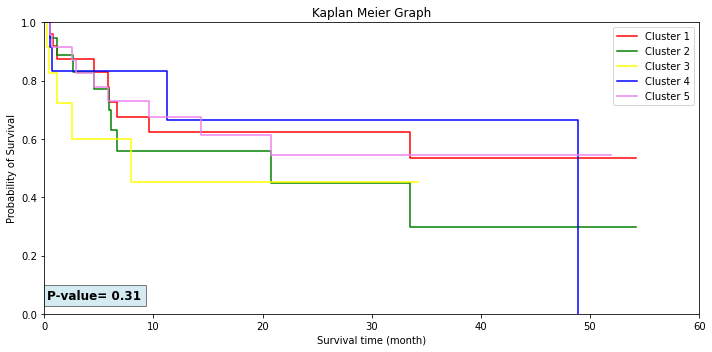

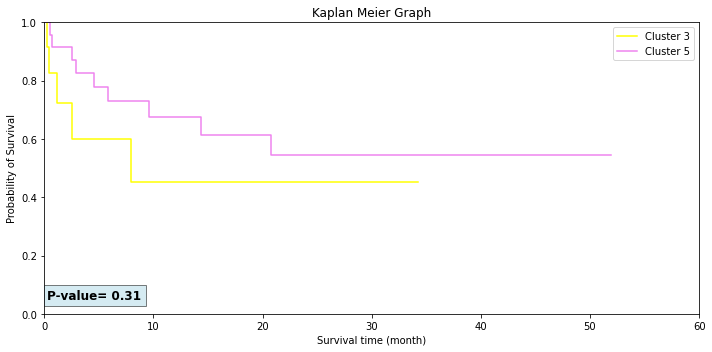

In [424]:
# Plot p-value with Kaplan Meier graphs of selected KMeans
print("Significant Clusters are: " , np.add(SignCluster,1))

# Possible to manually input the Significant needed to be plotted
#SignCluster = [1 , 2 , 4 , 6 ]

Clinical_data_new = KaplanMeierSurvivalFitter(labels , colors = colors, sample_ID_pixels = train_ID_pixels, Clinical_data = Clinical_data)
plt.text(0.30,0.05, "{}{}".format("P-value= ", pvalue) , fontsize = 12,fontweight="bold",bbox = dict(facecolor = 'lightblue', alpha = 0.5))


Clinical_data_new= KaplanMeierSurvivalFitter(labels , colors = colors, sample_ID_pixels = train_ID_pixels, Clinical_data = Clinical_data,SignCluster=SignCluster)
plt.text(0.30,0.05, "{}{}".format("P-value= ", pvalue) , fontsize = 12,fontweight="bold",bbox = dict(facecolor = 'lightblue', alpha = 0.5))

In [425]:
# Clusters_to_be_drawn = [ 0 , 2 ]
# Clinical_data_new= KaplanMeierSurvivalFitter(labels , colors = colors, sample_ID_pixels = train_ID_pixels, Clinical_data = Clinical_data,SignCluster=Clusters_to_be_drawn)
# plt.text(0.30,0.05, "{}{}".format("P-value= ", round(Results[Clusters_to_be_drawn[0]][Clusters_to_be_drawn[1]].p_value,2)) , fontsize = 12,fontweight="bold",bbox = dict(facecolor = 'lightblue', alpha = 0.5))

In [426]:
# Apply CoxHazard Fitter
cph = CoxHazardFitter(labels , Clinical_data = Clinical_data_new)

labels_count = len(np.unique(labels))

Clusters = [ [] for _ in range(labels_count)]
for cluster_label in range(labels_count):
    Clusters[cluster_label] = Clinical_data_new.query("Belong_Cluster_" + str(cluster_label+1) + " == 1")

# Clears output, can be commented if needed
from IPython.display import clear_output
clear_output()
plt.close()

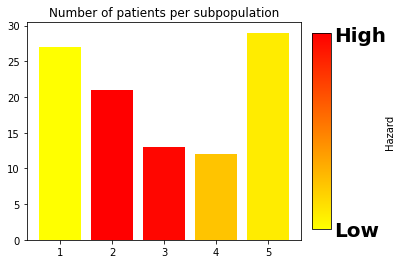

In [427]:
# Plot CoxHazard bar graph to show hazardous value of each cluster
labels_count = len(np.unique(labels))

Clusters = [ [] for _ in range(labels_count)]
for cluster_label in range(labels_count):
    Clusters[cluster_label] = Clinical_data_new.query("Belong_Cluster_" + str(cluster_label+1) + " == 1")
    
max_tick_value = max(cph.hazard_ratios_)
COLORS = ["yellow" , "red"]
CoxHazardBarPlot(cph = cph, colors = COLORS , max_tick_value = max_tick_value, clusters = Clusters)

In [ ]:
# Check for signifiance between 2 clusters using cluster_value - 1 if needed
# Results[5][6]

In [428]:
# Using coxhazard to determine the significant clusters, check coxhazard before relying on these values
hazardous_cluster_label = np.argmax(cph.hazard_ratios_) # Find the max hazard ratio's index and that will be the hazardous cluster label
survival_cluster_label = np.argmin(cph.hazard_ratios_) # Find the min hazard ratio's index and that will be the highest survival cluster label

print("Hazardous cluster label's index is {} and it is cluster {}".format(hazardous_cluster_label,hazardous_cluster_label+1))
print("High Survival cluster label's index is {} and it is cluster {}".format(survival_cluster_label,survival_cluster_label+1))

Hazardous cluster label's index is 1 and it is cluster 2
High Survival cluster label's index is 0 and it is cluster 1


In [430]:
# Manual input cluster labels if needed
survival_cluster_label = 0
hazardous_cluster_label = 2

print("Hazardous cluster label's index is {} and it is cluster {}".format(hazardous_cluster_label,hazardous_cluster_label+1))
print("Survival cluster label's index is {} and it is cluster {}".format(survival_cluster_label,survival_cluster_label+1))

Hazardous cluster label's index is 2 and it is cluster 3
Survival cluster label's index is 0 and it is cluster 1


In [431]:
# Perform SAM Analysis, Run R file after this cell
protein_dataframe = SAM_Analysis(labels, Clinical_data, train_ID_pixels, hazardous_cluster_label, train_data, peak_list)
protein_dataframe.to_csv("GastricCancerAverageSpectrumValues.csv",index=False)

# Run R file in order to generate significant proteins using the csv file

In [432]:
# Need to read significant protein file outputted from R, Create Target labels to be used for KNN and SVM Models

SAM_protein = readSignificantProteins("significant_gastric_proteins.json",delete=False)
SAM_protein = SAM_protein + readSignificantProteins("significant_gastric_proteins_up.json",delete=False)

SAM_protein_indices=[]
for i in range(len(peak_list)):

    if peak_list[i][0] in SAM_protein:
        SAM_protein_indices.append(i)

train_scaled_selected_proteins_data = train_scaled_data[:,SAM_protein_indices]
test_scaled_selected_proteins_data = test_scaled_data[:,SAM_protein_indices]

train_selected_proteins_data = train_data[:,SAM_protein_indices]
test_selected_proteins_data = test_data[:,SAM_protein_indices]

train_labels = TargetLabelsCreation(labels , Clinical_data, train_ID_pixels, hazardous_cluster_label , survival_cluster_label)

print(SAM_protein)

[3374, 3445, 3409, 3711, 3670, 3516, 3482, 3598, 13166]


In [433]:
# Creating DataFrame for the Classifier result

# df_Classifier_Quality = pd.DataFrame(columns=["Patient to be predicted/left out" , "Accuracy of Classifier" , "Precision" , "Recall", "F1-Score", "ROC AUC" , "Number of Clusters"])

# Load Classifier Quality Results csv
df_Classifier_Quality = pd.read_csv("Gastric_Classifier_Quality_Results.csv")


In [434]:
df_Classifier_Quality

,Patient to be predicted/left out,Accuracy of Classifier,Precision,Recall,F1-Score,ROC AUC,Number of Clusters
0,5,56.35,0.54,0.56,0.51,0.72,4
1,6,72.02,0.70,0.72,0.71,0.74,3
2,6,64.39,0.65,0.64,0.64,0.81,4
3,7,72.75,0.74,0.73,0.73,0.87,3
4,7,68.46,0.74,0.68,0.61,0.81,4


In [435]:
# Splitting data
from sklearn.model_selection import train_test_split

trainX, testX, trainy, testy = train_test_split(train_selected_proteins_data, train_labels, test_size=0.2, random_state=0)

In [436]:
# Check on y and train labels
print("All labels:")
increment = 0
test_labels = np.unique(train_labels,return_counts=True)
for i in test_labels[0]:
    print("Class {} has {} labels".format(i , test_labels[1][increment]))
    increment += 1

print("\nTrain labels: ")
increment = 0
test_train = np.unique(trainy,return_counts=True)
for i in test_train[0]:
    print("Class {} has {} labels".format(i , test_train[1][increment]))
    increment += 1

All labels:
Class 1 has 23101 labels
Class 2 has 13689 labels
Class 3 has 17242 labels

Train labels: 
Class 1 has 18524 labels
Class 2 has 10910 labels
Class 3 has 13791 labels


In [437]:
# Classifier Quality
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve , accuracy_score, ConfusionMatrixDisplay , f1_score, accuracy_score, precision_score, recall_score, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle


trainX, testX, trainy, testy = train_test_split(train_selected_proteins_data, train_labels, test_size=0.2, random_state=0)

# Checking Train accuracy 
from sklearn import svm

#Train the model using the training sets
SVM_model = svm.SVC(kernel="rbf"  , C = 0.1, random_state=0)
SVM_model.fit(trainX , trainy)

y_pred_SVM_roc = SVM_model.decision_function(testX)

In [438]:
# Predictions for SVM model
trainy_pred_SVM = SVM_model.predict(trainX)
y_pred_SVM = SVM_model.predict(testX)

In [439]:
# Checking Train accuracy
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

acc_train = accuracy_score(trainy, trainy_pred_SVM)
print("Accuracy of Train Data :", acc_train)

Accuracy of Train Data : 0.5573395026026605


Accuracy of Classifier is: 55.58
Precision:  0.68
Recall:  0.56
f1:  0.5


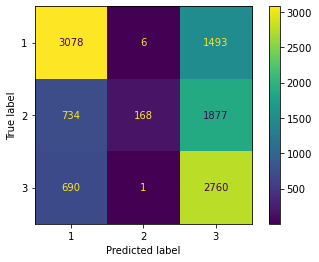

In [440]:
# Calculating accuracy score, precision, recall, f1 for the classifier
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

val_acc = accuracy_score(testy, y_pred_SVM)
print("Accuracy of Classifier is:", round(val_acc * 100,2))

val_acc=round(val_acc * 100,2)
precision = round(precision_score(testy, y_pred_SVM,average='weighted'),2)
recall= round(recall_score(testy, y_pred_SVM,average='weighted'),2)
f1score= round(f1_score(testy, y_pred_SVM,average='weighted'),2)

print("Precision: ", precision ) 
print("Recall: ",recall )
print("f1: ", f1score)
cm = confusion_matrix(testy , y_pred_SVM)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SVM_model.classes_)
disp.plot()
plt.show()

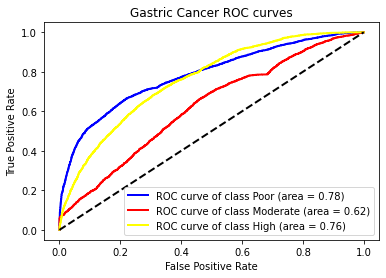

ROC AUC average is: 0.72


In [441]:
# roc curve for SVM model , using validation data

# Binarize the output
testy_binarized = label_binarize(testy, classes=[1, 2, 3])
n_classes = testy_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testy_binarized[:, i], y_pred_SVM_roc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors_ = cycle(['blue', 'red', 'yellow'])
labels = ["Poor" , "Moderate" , "High"]
for i, color in zip(range(n_classes), colors_):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gastric Cancer ROC curves')
plt.legend(loc="lower right")
plt.show()

auc_score = round(np.average(list(roc_auc.values())),2)
print("ROC AUC average is: {}".format(auc_score))

In [442]:
y_pred = SVM_model.predict(test_selected_proteins_data)
poor,moderate,high = ProbabilityCalc(y_pred)

Poor survival probability : 0.24906600249066002 
Moderate survival probability : 0 
High survival probability : 99.75093399750934


In [443]:
# Save Quality Analysis to csv file
df_Classifier_Quality_result = {}
df_Classifier_Quality_result["Patient to be predicted/left out"] = testPatient_ID
df_Classifier_Quality_result["Accuracy of Classifier"]= val_acc
df_Classifier_Quality_result["Precision"]= precision
df_Classifier_Quality_result["Recall"]= recall
df_Classifier_Quality_result["F1-Score"]= f1score
df_Classifier_Quality_result["ROC AUC"]= auc_score
df_Classifier_Quality_result["Number of Clusters"]= selected_clusters_value

df_Classifier_Quality_result = pd.DataFrame([df_Classifier_Quality_result])

df_Classifier_Quality = df_Classifier_Quality.append(df_Classifier_Quality_result)
df_Classifier_Quality.to_csv("Gastric_Classifier_Quality_Results.csv",index=False)

In [ ]:
#------------------------------------------------------------------------------------------------------------#

In [ ]:
# SVM Model , predicting labels
# Test rbf at c = 0.1 , 1 , 10
# Test linear at c = 0.1 , 1 , 10
y_pred_SVM = SVM("rbf" , 0.1 , train_selected_proteins_data , train_labels , test_selected_proteins_data)

In [ ]:
# Calculating SVM Probability survival values
Poor_Surv, Moderate_Surv , High_Surv = ProbabilityCalc(y_pred_SVM)
Surv_SVM = [Poor_Surv , Moderate_Surv, High_Surv]

In [418]:
# KNN Model, predicting labels
y_pred_KNN = KNN(5, train_selected_proteins_data, train_labels, test_selected_proteins_data)

In [419]:
# Calculating KNN Probability survival values
Poor_Surv, Moderate_Surv , High_Surv  = ProbabilityCalc(y_pred_KNN)
Surv_KNN = [Poor_Surv , Moderate_Surv, High_Surv]

Poor survival probability : 0 
Moderate survival probability : 84.18430884184309 
High survival probability : 15.81569115815691


In [ ]:
# # Random Forest Classifier
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(max_depth=5, random_state=0)
# clf.fit(train_selected_proteins_data, train_labels)
# y_pred = clf.predict(test_selected_proteins_data)

# Poor_Surv, Moderate_Surv , High_Surv  = ProbabilityCalc(y_pred)

In [ ]:
# Selecting KNN as outputted results
Selected_model = Surv_KNN
Poor_Surv = round(Selected_model[0],2)
Moderate_Surv = round(Selected_model[1],2)
High_Surv = round(Selected_model[2],2)

In [ ]:
# Run after model complete to save the result in the total results dataframe, outputting KNN results in dataframe
# total_results_dataframe_KNN = OutputDataframe(total_results_dataframe_KNN, testPatient_ID , Clinical_data_full, Poor_Surv , Moderate_Surv, High_Surv ,selected_clusters_value, SAM_protein)

In [ ]:
# Preview KNN results
# total_results_dataframe_KNN

In [ ]:
# Saving KNN results in CSV file
# Only run if needed to save and load at a later time
# total_results_dataframe_KNN.to_csv("total_GastricCancer_results_KNN.csv" , index = False)

In [ ]:
# Selecting SVM as outputted results

Selected_model = Surv_SVM
Poor_Surv = round(Selected_model[0],2)
Moderate_Surv = round(Selected_model[1],2)
High_Surv = round(Selected_model[2],2)

In [ ]:
# Run after model complete to save the result in the total results dataframe, outputting SVM results in dataframe
# total_results_dataframe_SVM = OutputDataframe(total_results_dataframe_SVM, testPatient_ID , Clinical_data_full, Poor_Surv , Moderate_Surv, High_Surv ,selected_clusters_value, SAM_protein)

In [ ]:
# Preview SVM results
# total_results_dataframe_SVM

In [ ]:
# Saving SVM results in CSV file
# Only run if needed to save and load at a later time
# total_results_dataframe_SVM.to_csv("total_GastricCancer_results_SVM.csv" , index = False)